# C3 FC percentile validation

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the`DEA Sandbox` environments
* **Products used:** 
[mangrove_cover](https://explorer.sandbox.dea.ga.gov.au/products/mangrove_cover), 
C3 mangroves test product

## Description
The notebook is to validate the new C3 mangrove_cover product against the C2 product `mangrove_cover`. It produced the output for the validation report.

1. Generate and plot the differences between `C3` and `C2`
2. Plot the single grid for the visual check

***

## Getting started

Install the package needed by

`!pip install awswrangler`

in the top cell or the terminal then restart notebook.

In [1]:
import datacube
import rasterio
import boto3
import xarray as xr
import numpy as np
import re
from datacube.utils.dask import start_local_dask
from datacube import Datacube
from osgeo import ogr, gdal, osr
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as sps
import awswrangler as wr
import rioxarray as rioxr

from datacube.utils.dask import start_local_dask
from datacube import Datacube
from odc.algo.io import load_with_native_transform
from odc.algo import keep_good_only
from odc.algo._percentile import xr_quantile_bands
from odc.algo._masking import _xr_fuse, _fuse_mean_np, enum_to_bool
from functools import partial

In [4]:
# create a local cluster
client = start_local_dask(n_workers=1, threads_per_worker=60, memory_limit='400GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 60,Total memory: 372.53 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45083,Workers: 1
Dashboard: /user/emma.ai@ga.gov.au/proxy/8787/status,Total threads: 60
Started: Just now,Total memory: 372.53 GiB
Comm: tcp://127.0.0.1:45123,Total threads: 60
Dashboard: /user/emma.ai@ga.gov.au/proxy/43727/status,Memory: 372.53 GiB
Nanny: tcp://127.0.0.1:39315,


In [5]:
# `dev` is the credential profile name
# change it accordingly
session = boto3.Session()
mangroves_bucket = "s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/"

In [6]:
# list all the available file paths/prefix
mangroves_x_dirs = wr.s3.list_directories(mangroves_bucket, boto3_session=session)
mangroves_file_dirs = []
for x_idx in mangroves_x_dirs:
    mangroves_file_dirs += wr.s3.list_directories(x_idx, boto3_session=session)

In [7]:
mangroves_file_dirs

['s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x08/y31/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x17/y37/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x18/y37/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x18/y38/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y37/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y38/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y39/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y40/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y38/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y39/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y40/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y41/',
 's3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x21/y40/',
 's3://dea-public-data-de

In [8]:
def generate_rasterize(shape_file, data):
    source_ds = ogr.Open(shape_file)
    source_layer = source_ds.GetLayer()
    source_layer.SetAttributeFilter("Mang_IBRA='Kimberley Coast'")

    yt, xt = data[0].shape
    xres = 30
    yres = -30
    no_data = 0

    xcoord = data.coords["x"].min()
    ycoord = data.coords["y"].max()
    geotransform = (xcoord - (xres * 0.5), xres, 0, ycoord - (yres * 0.5), 0, yres)

    target_ds = gdal.GetDriverByName("MEM").Create("", xt, yt, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geotransform)
    albers = osr.SpatialReference()
    albers.ImportFromEPSG(3577)
    target_ds.SetProjection(albers.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(no_data)

    gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])
    return band.ReadAsArray()

1.1 Generate the difference for each grid in the list
-----

In [3]:
dc = Datacube()

In [9]:
region_grids = ['x18y37',
 'x18y38',
 'x18y39',
 'x19y37',
 'x19y38',
 'x19y39',
 'x19y40',
 'x20y36',
 'x20y37',
 'x20y38',
 'x20y39',
 'x20y40',
 'x20y41',
 'x21y36',
 'x21y37',
 'x21y38',
 'x21y39',
 'x21y40',
 'x21y41',
 'x22y35',
 'x22y36',
 'x22y37',
 'x22y38',
 'x22y39',
 'x22y40',
 'x22y41',
 'x23y36',
 'x23y37',
 'x23y38',
 'x23y39',
 'x23y40',
 'x23y41']

In [14]:
mangroves_shape = "IBRA_Regions/IBRA_MERGED_coastal.shp"
name_list = {0: 'not_observed', 1: 'woodland', 2: 'open_forest', 3: 'closed_forest'}

In [ ]:
results = None
for g in region_grids:
    f_dir = mangroves_bucket + '/'.join(re.findall(r'\w\d+', g)) + '/'
    if f_dir in mangroves_file_dirs:
        dataset = None
        for i in range(1987, 2021):
            non_empty_list = wr.s3.list_objects(f_dir + str(i) + "--P1Y", boto3_session=session, suffix=['tiff'])
            if non_empty_list == []:
                continue
            for o in non_empty_list:
                data = rioxr.open_rasterio(o, chunks={'x':3200, 'y':3200})
                data.name = "canopy_cover_class"
            tmp_set = data.to_dataset()
            tmp_set = tmp_set.rename_dims({'band': 'time'})
            tmp_set = tmp_set.rename_vars({'band': 'time'})
            tmp_set.time.data[0] = i
            if dataset is None:
                dataset = tmp_set
            else:
                dataset = xr.concat([dataset, tmp_set], dim='time')
        mangroves_mask = generate_rasterize(mangroves_shape, dataset.canopy_cover_class)
        res = {}
        for i in range(4):
            res[i] = dataset.canopy_cover_class.where((dataset.canopy_cover_class==i) & mangroves_mask).count(axis=[1, 2])
            res[i].name = name_list[i]
        if results is None:
            results = xr.merge(res.values()).to_dataframe()
        else:
            results += xr.merge(res.values()).to_dataframe()

In [ ]:
results

In [ ]:
    ax = (results * (30**2) /1e6).plot.bar(stacked=True, figsize=(10,7), color=['#808080', '#9FFF4C', '#5ECC00', '#3B7F00'], legend=False, width=1.0)
    ax.set_title("Kimberley Coast", fontweight="bold", fontsize=16)
    ax.set_xlabel('Time (Years)')
    ax.set_ylabel('Area (km$^{2}$)')
    plt.savefig("Kimberley_Coast_C3_dilation_6" + '.png')

In [41]:
def _version(dataset):
    return dataset.metadata_doc['properties']['odc:dataset_version'] == '3.0.0'

In [42]:
# loop over the path/prefix of all the test grids
# calculate the difference of area
for f_dir in mangroves_file_dirs:
    dataset = None
    for i in range(1987, 2023):
        non_empty_list = wr.s3.list_objects(f_dir + str(i) + "--P1Y", boto3_session=session, suffix=['tiff'])
        if non_empty_list == []:
            continue
        for o in non_empty_list:
            data = rioxr.open_rasterio(o, chunks={'x':3200, 'y':3200})
            data.name = "canopy_cover_class"
        tmp_set = data.to_dataset()
        tmp_set = tmp_set.rename_dims({'band': 'time'})
        tmp_set = tmp_set.rename_vars({'band': 'time'})
        tmp_set.time.data[0] = i
        if dataset is None:
            dataset = tmp_set
        else:
            dataset = xr.concat([dataset, tmp_set], dim='time')
    # query and load C2 by the geolocation of grid
    print(f_dir)
    query = {'time':('1987-01-01', '2023-01-01'), 'x': (dataset.x.data.min() - 15, dataset.x.data.max() + 15), 'y': (dataset.y.data.min() - 15, dataset.y.data.max() + 15), 'crs': 'EPSG:3577'}
    c2_data = dc.load(product='ga_ls_mangrove_cover_cyear_3', **query,
                      dataset_predicate=_version, 
                      measurements=['canopy_cover_class'], dask_chunks={'time':1})
    c2_data = c2_data.assign_coords(time=dataset.time.data)
    # save the results to csvs
    # named after grid index and product version, e.g., x17_y37.csv
    sum_res = dataset.canopy_cover_class.where(dataset.canopy_cover_class == 0).count(['x', 'y']).to_dataset(name='c3_class_d6_0')
    c2_sum = c2_data.canopy_cover_class.where(c2_data.canopy_cover_class == 0).count(['x', 'y'])
    sum_res = sum_res.update(c2_sum.to_dataset(name='c2_class_0').drop("spatial_ref"))
    for j in range(1, 4):
        sum_res = sum_res.update(dataset.canopy_cover_class.where(dataset.canopy_cover_class == j).count(['x', 'y']).to_dataset(name='c3_class_d6_' + str(j)))
        c2_sum = c2_data.canopy_cover_class.where(c2_data.canopy_cover_class == j).count(['x', 'y'])
        sum_res = sum_res.update(c2_sum.to_dataset(name='c2_class_' + str(j)).drop("spatial_ref"))
    sum_res.load().to_dataframe().to_csv("_".join(f_dir.split('/')[-3:-1]) + "_d6nff.csv")

s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x08/y31/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x17/y37/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x18/y37/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x18/y38/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y37/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y38/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y39/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x19/y40/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y38/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y39/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y40/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x20/y41/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x21/y40/
s3://dea-public-data-dev/test/mangroves-dilation-6-dilation-6/x21/y41/
s3://d

1.2. Plot the difference of classes
--------------------

In [43]:
c2_class = []
c3_class_d6 = []
for i in range(4):
    c3_class_d6 += ["c3_class_d6_" + str(i)]
    c2_class += ["c2_class_" + str(i)]

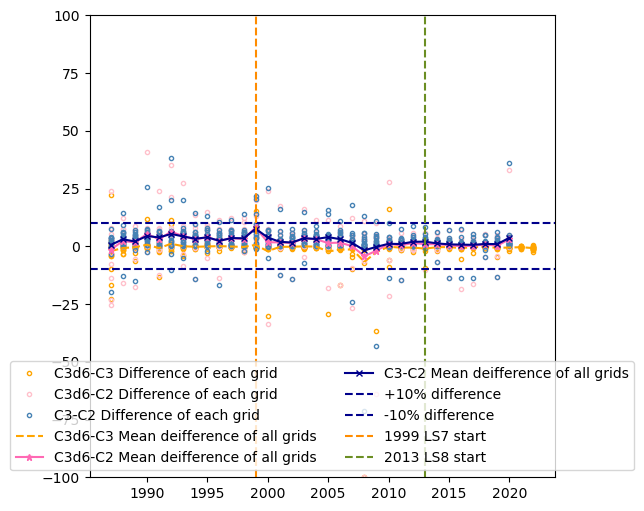

In [44]:
# plot the difference of all classes
fig = plt.figure(figsize=(6, 6))
diff_perc = None
diff_perc_2 = None
diff_perc_3 = None
for f_dir in mangroves_file_dirs:
    tile_name = '_'.join(f_dir.split('/')[-3:-1])
    if not (os.path.exists(tile_name+'_d6nff.csv') & os.path.exists(tile_name+'_nff.csv')):
        continue
    sum_res = pd.read_csv(tile_name+'_d6nff.csv', index_col=0)
    sum_res_c2 = pd.read_csv(tile_name+'_nff.csv', index_col=0)
    if diff_perc is None:
        diff_perc = (sum_res[c3_class_d6[0:]].sum(axis=1) * (30**2) / (sum_res[c2_class[0:]].sum(axis=1) * (30**2))) - 1
        diff_perc_2 = (sum_res[c3_class_d6[0:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[0:]].sum(axis=1) * (25**2))) - 1
        diff_perc_3 = (sum_res[c2_class[0:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[0:]].sum(axis=1) * (25**2))) - 1
    else:
        diff_perc = pd.concat([diff_perc, (sum_res[c3_class_d6[0:]].sum(axis=1) * (30**2) / (sum_res[c2_class[0:]].sum(axis=1) * (30**2))) - 1], axis=1)
        diff_perc_2 = pd.concat([diff_perc_2, (sum_res[c3_class_d6[0:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[0:]].sum(axis=1) * (25**2))) - 1], axis=1)
        diff_perc_3 = pd.concat([diff_perc_3, (sum_res[c2_class[0:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[0:]].sum(axis=1) * (25**2))) - 1], axis=1)
        
plt.plot(diff_perc.iloc[:, 0] * 100, 'o', color='orange',  mfc='none', markersize=3, label="C3d6-C3 Difference of each grid")
plt.plot(diff_perc.iloc[:, 1:] * 100, 'o', color='orange',  mfc='none', markersize=3)
plt.plot(diff_perc_2.iloc[:, 0] * 100, 'o', color='pink',  mfc='none', markersize=3, label="C3d6-C2 Difference of each grid")
plt.plot(diff_perc_2.iloc[:, 1:] * 100, 'o', color='Pink',  mfc='none', markersize=3)
plt.plot(diff_perc_3.iloc[:, 0] * 100, 'o', color='SteelBlue',  mfc='none', markersize=3, label="C3-C2 Difference of each grid")
plt.plot(diff_perc_3.iloc[:, 1:] * 100, 'o', color='SteelBlue',  mfc='none', markersize=3)
plt.ylim(-100, 100)
plt.plot(diff_perc.mean(axis=1) * 100, '--', color='orange', markersize=5, label="C3d6-C3 Mean deifference of all grids")
plt.plot(diff_perc_2.mean(axis=1) * 100, '-*', color='hotpink', markersize=5, label="C3d6-C2 Mean deifference of all grids")
plt.plot(diff_perc_3.mean(axis=1) * 100, '-x', color='DarkBlue', markersize=5, label="C3-C2 Mean deifference of all grids")
plt.axhline(y=10, linestyle='--', color='darkblue', label="+10% difference")
plt.axhline(y=-10, linestyle='--', color='darkblue', label="-10% difference")
plt.axvline(x=1999, linestyle='--', color='darkorange', label='1999 LS7 start')
plt.axvline(x=2013, linestyle='--', color='OliveDrab', label='2013 LS8 start')
plt.legend(loc='lower center', ncol=2)
plt.savefig("all_classes_diff_with_0.png", bbox_inches='tight')

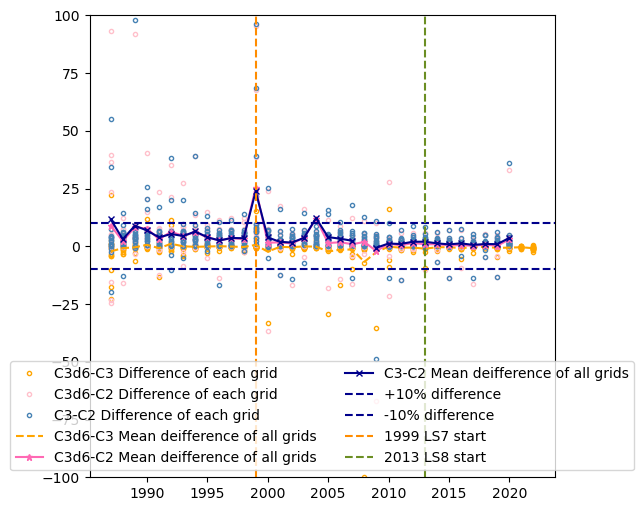

In [45]:
# plot the difference of all classes
fig = plt.figure(figsize=(6, 6))
diff_perc = None
diff_perc_2 = None
diff_perc_3 = None
for f_dir in mangroves_file_dirs:
    tile_name = '_'.join(f_dir.split('/')[-3:-1])
    if not (os.path.exists(tile_name+'_d6nff.csv') & os.path.exists(tile_name+'_nff.csv')):
        continue
    sum_res = pd.read_csv(tile_name+'_d6nff.csv', index_col=0)
    sum_res_c2 = pd.read_csv(tile_name+'_nff.csv', index_col=0)
    if diff_perc is None:
        diff_perc = (sum_res[c3_class_d6[1:]].sum(axis=1) * (30**2) / (sum_res[c2_class[1:]].sum(axis=1) * (30**2))) - 1
        diff_perc_2 = (sum_res[c3_class_d6[1:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[1:]].sum(axis=1) * (25**2))) - 1
        diff_perc_3 = (sum_res[c2_class[1:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[1:]].sum(axis=1) * (25**2))) - 1
    else:
        diff_perc = pd.concat([diff_perc, (sum_res[c3_class_d6[1:]].sum(axis=1) * (30**2) / (sum_res[c2_class[1:]].sum(axis=1) * (30**2))) - 1], axis=1)
        diff_perc_2 = pd.concat([diff_perc_2, (sum_res[c3_class_d6[1:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[1:]].sum(axis=1) * (25**2))) - 1], axis=1)
        diff_perc_3 = pd.concat([diff_perc_3, (sum_res[c2_class[1:]].sum(axis=1) * (30**2) / (sum_res_c2[c2_class[1:]].sum(axis=1) * (25**2))) - 1], axis=1)
        
plt.plot(diff_perc.iloc[:, 0] * 100, 'o', color='orange',  mfc='none', markersize=3, label="C3d6-C3 Difference of each grid")
plt.plot(diff_perc.iloc[:, 1:] * 100, 'o', color='orange',  mfc='none', markersize=3)
plt.plot(diff_perc_2.iloc[:, 0] * 100, 'o', color='pink',  mfc='none', markersize=3, label="C3d6-C2 Difference of each grid")
plt.plot(diff_perc_2.iloc[:, 1:] * 100, 'o', color='Pink',  mfc='none', markersize=3)
plt.plot(diff_perc_3.iloc[:, 0] * 100, 'o', color='SteelBlue',  mfc='none', markersize=3, label="C3-C2 Difference of each grid")
plt.plot(diff_perc_3.iloc[:, 1:] * 100, 'o', color='SteelBlue',  mfc='none', markersize=3)
plt.ylim(-100, 100)
plt.plot(diff_perc.mean(axis=1) * 100, '--', color='orange', markersize=5, label="C3d6-C3 Mean deifference of all grids")
plt.plot(diff_perc_2.mean(axis=1) * 100, '-*', color='hotpink', markersize=5, label="C3d6-C2 Mean deifference of all grids")
plt.plot(diff_perc_3.mean(axis=1) * 100, '-x', color='DarkBlue', markersize=5, label="C3-C2 Mean deifference of all grids")
plt.axhline(y=10, linestyle='--', color='darkblue', label="+10% difference")
plt.axhline(y=-10, linestyle='--', color='darkblue', label="-10% difference")
plt.axvline(x=1999, linestyle='--', color='darkorange', label='1999 LS7 start')
plt.axvline(x=2013, linestyle='--', color='OliveDrab', label='2013 LS8 start')
plt.legend(loc='lower center', ncol=2)
plt.savefig("all_classes_diff_without_0.png", bbox_inches='tight')

x08_y31
x17_y37
x18_y37
x18_y38
x19_y37
x19_y38
x19_y39
x19_y40
x20_y38
x20_y39
x20_y40
x20_y41
x21_y40
x21_y41
x22_y41
x23_y39
x23_y40
x23_y41
x24_y40
x27_y43
x28_y42
x28_y43
x31_y40
x34_y17
x37_y36
x38_y37
x38_y40
x39_y13
x42_y37
x42_y38
x43_y35
x45_y15
x45_y16
x46_y17
x48_y27
x49_y23
x49_y24
x08_y31
x17_y37
x18_y37
x18_y38
x19_y37
x19_y38
x19_y39
x19_y40
x20_y38
x20_y39
x20_y40
x20_y41
x21_y40
x21_y41
x22_y41
x23_y39
x23_y40
x23_y41
x24_y40
x27_y43
x28_y42
x28_y43
x31_y40
x34_y17
x37_y36
x38_y37
x38_y40
x39_y13
x42_y37
x42_y38
x43_y35
x45_y15
x45_y16
x46_y17
x48_y27
x49_y23
x49_y24
x08_y31
x17_y37
x18_y37
x18_y38
x19_y37
x19_y38
x19_y39
x19_y40
x20_y38
x20_y39
x20_y40
x20_y41
x21_y40
x21_y41
x22_y41
x23_y39
x23_y40
x23_y41
x24_y40
x27_y43
x28_y42
x28_y43
x31_y40
x34_y17
x37_y36
x38_y37
x38_y40
x39_y13
x42_y37
x42_y38
x43_y35
x45_y15
x45_y16
x46_y17
x48_y27
x49_y23
x49_y24


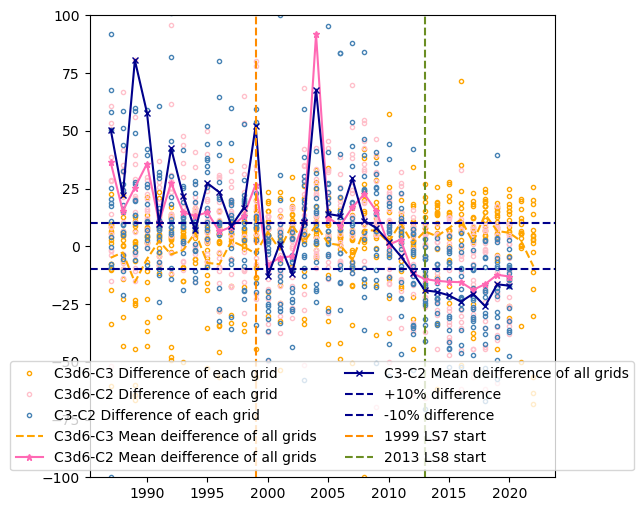

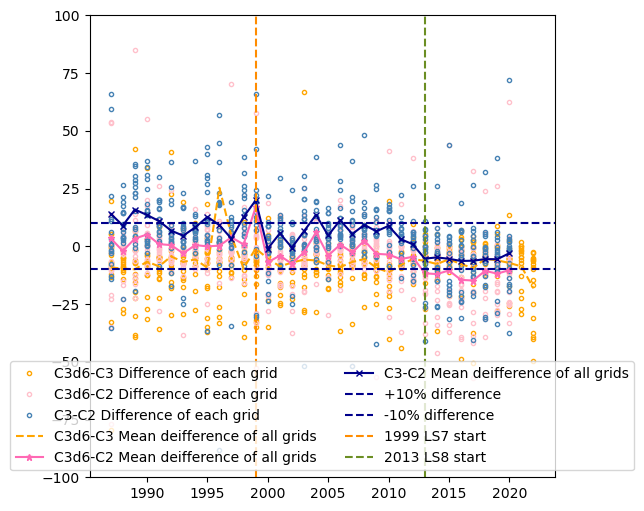

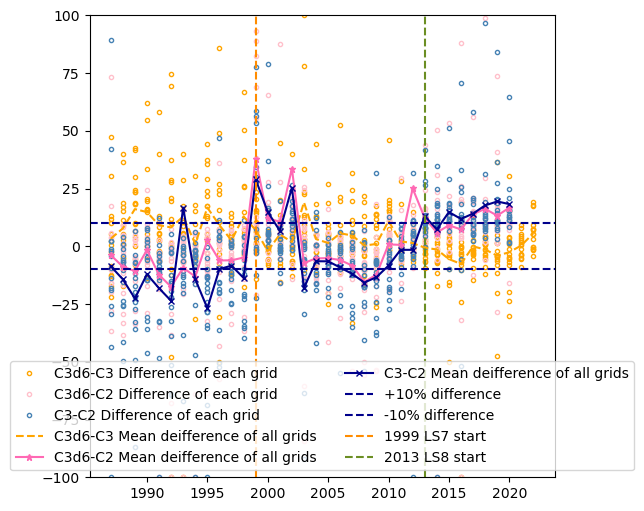

In [46]:
# plot the difference of each class
for i in range(1,4):
    fig = plt.figure(figsize=(6, 6))
    diff_perc = None
    diff_perc_2 = None
    diff_perc_3 = None
    for f_dir in mangroves_file_dirs:
        tile_name = '_'.join(f_dir.split('/')[-3:-1])
        print(tile_name)
        if not (os.path.exists(tile_name+'_d6nff.csv') & os.path.exists(tile_name+'_nff.csv')):
            continue
        sum_res = pd.read_csv(tile_name+'_d6nff.csv', index_col=0)
        sum_res_c2 = pd.read_csv(tile_name+'_nff.csv', index_col=0)
        if diff_perc is None:
            diff_perc = (sum_res[c3_class_d6[i]]* (30**2) / (sum_res[c2_class[i]] * (30**2))) - 1
            diff_perc_2 = (sum_res[c3_class_d6[i]] * (30**2) / (sum_res_c2[c2_class[i]] * (25**2))) - 1
            diff_perc_3 = (sum_res[c2_class[i]] * (30**2) / (sum_res_c2[c2_class[i]] * (25**2))) - 1
        else:
            diff_perc = pd.concat([diff_perc, (sum_res[c3_class_d6[i]] * (30**2) / (sum_res[c2_class[i]] * (30**2))) - 1], axis=1)
            diff_perc_2 = pd.concat([diff_perc_2, (sum_res[c3_class_d6[i]] * (30**2) / (sum_res_c2[c2_class[i]]* (25**2))) - 1], axis=1)
            diff_perc_3 = pd.concat([diff_perc_3, (sum_res[c2_class[i]] * (30**2) / (sum_res_c2[c2_class[i]]* (25**2))) - 1], axis=1)
    diff_perc[diff_perc==np.inf] = np.nan
    diff_perc_2[diff_perc_2==np.inf] = np.nan
    diff_perc_3[diff_perc_3==np.inf] = np.nan
    plt.plot(diff_perc.iloc[:, 0] * 100, 'o', color='orange',  mfc='none', markersize=3, label="C3d6-C3 Difference of each grid")
    plt.plot(diff_perc.iloc[:, 1:] * 100, 'o', color='orange',  mfc='none', markersize=3)
    plt.plot(diff_perc_2.iloc[:, 0] * 100, 'o', color='pink',  mfc='none', markersize=3, label="C3d6-C2 Difference of each grid")
    plt.plot(diff_perc_2.iloc[:, 1:] * 100, 'o', color='Pink',  mfc='none', markersize=3)
    plt.plot(diff_perc_3.iloc[:, 0] * 100, 'o', color='SteelBlue',  mfc='none', markersize=3, label="C3-C2 Difference of each grid")
    plt.plot(diff_perc_3.iloc[:, 1:] * 100, 'o', color='SteelBlue',  mfc='none', markersize=3)
    plt.ylim(-100, 100)
    plt.plot(diff_perc.mean(axis=1) * 100, '--', color='orange', markersize=5, label="C3d6-C3 Mean deifference of all grids")
    plt.plot(diff_perc_2.mean(axis=1) * 100, '-*', color='hotpink', markersize=5, label="C3d6-C2 Mean deifference of all grids")
    plt.plot(diff_perc_3.mean(axis=1) * 100, '-x', color='DarkBlue', markersize=5, label="C3-C2 Mean deifference of all grids")
    plt.axhline(y=10, linestyle='--', color='darkblue', label="+10% difference")
    plt.axhline(y=-10, linestyle='--', color='darkblue', label="-10% difference")
    plt.axvline(x=1999, linestyle='--', color='darkorange', label='1999 LS7 start')
    plt.axvline(x=2013, linestyle='--', color='OliveDrab', label='2013 LS8 start')
    plt.legend(loc='lower center', ncol=2)
    plt.savefig("class_diff_" + str(i) + ".png", bbox_inches='tight')
    #plt.close()

2.. Plot mangroves cover classes of any testing grid
---------------------

In [7]:
# plot fc percentile band as required
# reading data is the same as in the loop of computation above
f_dir = mangroves_bucket + 'x43/y35/'
dataset = None
for i in range(1987, 2021):
    non_empty_list = wr.s3.list_objects(f_dir + str(i) + "--P1Y", boto3_session=session, suffix=['tiff'])
    if non_empty_list == []:
        continue
    for o in non_empty_list:
        data = xr.open_rasterio(o, chunks={'x':3200, 'y':3200})
        data.name = "canopy_cover_class"
    tmp_set = data.to_dataset()
    tmp_set = tmp_set.rename_dims({'band': 'time'})
    tmp_set = tmp_set.rename_vars({'band': 'time'})
    tmp_set.time.data[0] = i
    if dataset is None:
        dataset = tmp_set
    else:
        dataset = xr.concat([dataset, tmp_set], dim='time')
query = {'time':('1987-01-01', '2021-01-01'), 'x': (dataset.x.data.min() - 15, dataset.x.data.max() + 15), 'y': (dataset.y.data.min() - 15, dataset.y.data.max() + 15), 'crs': 'EPSG:3577'}
c2_data = dc.load(product='mangrove_cover', **query, measurements=["canopy_cover_class"], dask_chunks={'time':1})


In [8]:
closed_forest = ((dataset.canopy_cover_class >= 1) & (dataset.canopy_cover_class <255)).astype('int8')
long_last = (closed_forest.loc[dict(time=slice(1987,2009))].sum(dim='time') + 
             closed_forest.loc[dict(time=slice(2014,2020))].sum(dim='time') >= 25)

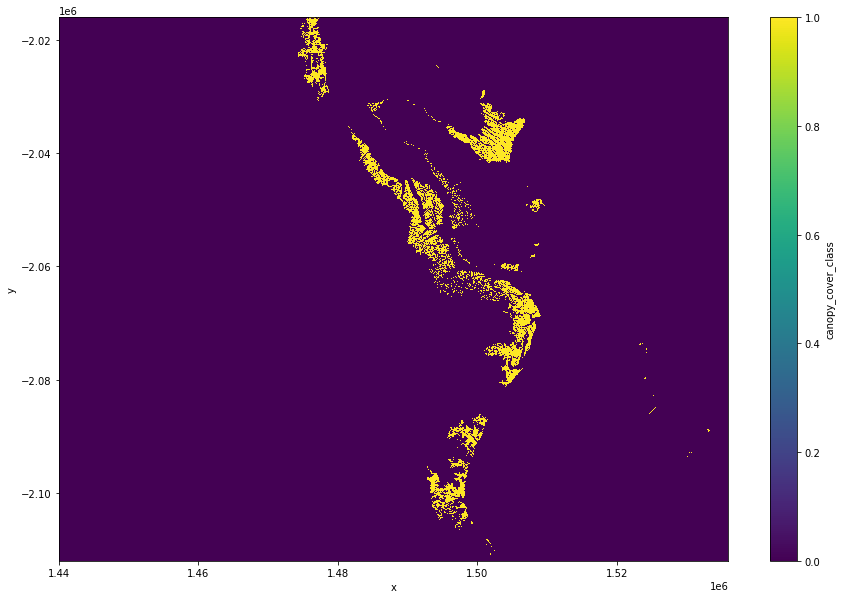

In [10]:
long_last.compute().plot(aspect=1.5, size=10)

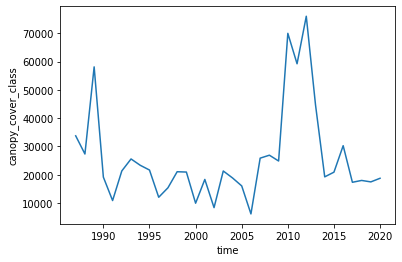

In [19]:
time_count = (~((dataset.canopy_cover_class >= 1) & (dataset.canopy_cover_class < 255)) & long_last).sum(dim=['x', 'y']).compute()
time_count.plot()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2021

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 8`, :index:`landsat 7`, :index: `landsat 5`, :index: `mangrove`